In [132]:
!git clone https://github.com/AlicePH/NLA-project.git

Cloning into 'NLA-project'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 87 (delta 33), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (87/87), done.


In [134]:
%cd /content/NLA-project/models

/content/NLA-project/models


In [136]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import time
from layer_decomposer import low_rank_dec

**Experiments**

***Simple Neural Network:***

In [14]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))])

trainset = torchvision.datasets.CIFAR10(root='./data/', 
                                        train=True,
                                        download=True, 
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=64,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False,
                                       download=True, 
                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=64,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [137]:
class Net_Large_Experiments(nn.Module):
    def __init__(self, filters_num):
        super(Net_Large_Experiments, self).__init__()

        self.filters_num = filters_num # vary this parameter: the higher it is, the longer net trains

        self.conv1 = nn.Conv2d(3, self.filters_num, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(self.filters_num, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        self.replace = False


    def replace_conv(self, rank, rank2):
        self.replace = True
        f, c_i, k = self.filters_num, 3, 5
        f2, c_i2, k2 = 16, self.filters_num, 5


        filters1 = self.conv1.weight
        u1, v1 = low_rank_dec(filters1, rank)

        self.conv1_replace_1 = nn.Conv2d(in_channels=c_i, out_channels=rank, kernel_size=k)
        self.conv1_replace_1.load_state_dict({'weight': v1}, strict=False)

        self.conv1_replace_2 = nn.Conv2d(in_channels=rank, out_channels=f, kernel_size=1)
        self.conv1_replace_2.load_state_dict({'weight': u1}, strict=False)




        filters2 = self.conv2.weight
        u2, v2 = low_rank_dec(filters2, rank2)

        self.conv2_replace_1 = nn.Conv2d(in_channels=c_i2, out_channels=rank2, kernel_size=k2)
        self.conv2_replace_1.load_state_dict({'weight': v2}, strict=False)

        self.conv2_replace_2 = nn.Conv2d(in_channels=rank2, out_channels=f2, kernel_size=1)
        self.conv2_replace_2.load_state_dict({'weight': u2}, strict=False)

    def forward(self, x):
      if not self.replace:
    
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

      else:

        x = self.conv1_replace_1(x)
        x = self.conv1_replace_2(x)

        x = self.pool(F.relu(x))

        x = self.conv2_replace_1(x)
        x = self.conv2_replace_2(x)

        x = self.pool(F.relu(x))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

      return x

In [64]:
def experiment(net, epochs):

    print('Training')
      
    model_directory_path = 'model/'
    model_path = model_directory_path + 'cifar-10-cnn-model.pt'

    start_time = time.time()
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
    print('Finished Training.')
    # torch.save(net.state_dict(), model_path)
    # print('Saved model parameters to disk.')


    print('Prediction')


    total_correct = 0
    total_images = 0
    confusion_matrix = np.zeros([10,10], int)
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            for i, l in enumerate(labels):
                confusion_matrix[l.item(), predicted[i].item()] += 1 

    _time = time.time() - start_time

    model_accuracy = total_correct / total_images * 100
    print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

    print('{0:10s} - {1}'.format('Category','Accuracy'))
    for i, r in enumerate(confusion_matrix):
        print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

    return _time, model_accuracy


In [65]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [94]:
epoch = 1
param_filt = [6, 30, 60, 200, 600]

TIME_full_rk = []
ACCURACY_full_rk = []

TIME_low_rk = []
ACCURACY_low_rk = []

for number_filt in param_filt:

  net = Net_Large_Experiments(number_filt)
  optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
  print(net)

  time_exp, acc_exp = experiment(net, epoch)
  TIME_full_rk.append(time_exp)
  ACCURACY_full_rk.append(acc_exp)

  rk = min([int(number_filt / 4), 7])
  net.replace_conv(rk, rk)
  print(net)

  time_exp_l, acc_exp_l = experiment(net, epoch)
  TIME_low_rk.append(time_exp_l)
  ACCURACY_low_rk.append(acc_exp_l)

  print()
  print()


Net_Large_Experiments(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Training
[1,    10] loss: 0.012
[1,    20] loss: 0.012
[1,    30] loss: 0.012
[1,    40] loss: 0.012
[1,    50] loss: 0.011
[1,    60] loss: 0.012
[1,    70] loss: 0.012
[1,    80] loss: 0.011
[1,    90] loss: 0.011
[1,   100] loss: 0.012
[1,   110] loss: 0.011
[1,   120] loss: 0.011
[1,   130] loss: 0.011
[1,   140] loss: 0.011
[1,   150] loss: 0.012
[1,   160] loss: 0.011
[1,   170] loss: 0.012
[1,   180] loss: 0.011
[1,   190] loss: 0.011
[1,   200] loss: 0.011
[1,   210] loss: 0.011
[1,   220] loss: 0.011
[1,   230] loss: 0.011
[1,   240] loss: 0.011
[1,   250] loss: 0.011
[1, 

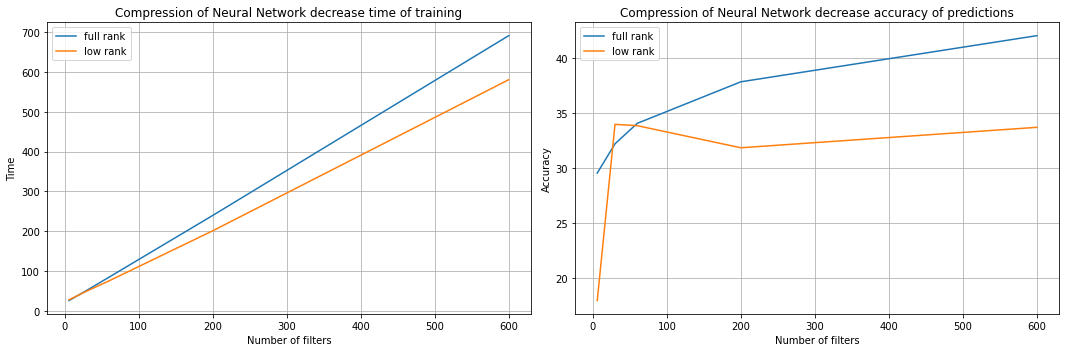

In [124]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(15, 5))


axs[0].plot(param_filt, TIME_full_rk, label='full rank')
axs[0].plot(param_filt, TIME_low_rk, label='low rank')
axs[0].set_ylabel('Time')
axs[0].set_xlabel('Number of filters')
axs[0].grid(True)
axs[0].legend()
axs[0].set_title('Compression of Neural Network decrease time of training')


axs[1].plot(param_filt, ACCURACY_full_rk, label='full rank')
axs[1].plot(param_filt, ACCURACY_low_rk, label='low rank')
axs[1].set_ylabel('Accuracy')
axs[1].grid(True)
axs[1].set_xlabel('Number of filters')
axs[1].legend()
axs[1].set_title('Compression of Neural Network decrease accuracy of predictions')

fig.tight_layout()
plt.savefig('experiment1.png')

plt.show()


In [131]:
print('time saving', 100 * np.mean((np.array(TIME_full_rk) - np.array(TIME_low_rk)) / np.array(TIME_full_rk)), '%')
print('accuracy loss', 100 * np.mean((np.array(ACCURACY_full_rk) - np.array(ACCURACY_low_rk)) / np.array(ACCURACY_full_rk)), '%')

tive saving 7.850091662635582 %
accuracy loss 14.020724318240413 %
